In [1]:
%tensorflow_version 2.x
import tensorflow as     tf
from   tensorflow import keras

# tensorflow datasets
import tensorflow_datasets as tfds

# additional libraries
import math
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

# model
MODEL_LEVEL_0_BLOCKS    = 4
MODEL_LEVEL_1_BLOCKS    = 6
MODEL_LEVEL_2_BLOCKS    = 3

# training
TRAINING_BATCH_SIZE      = 32
TRAINING_SHUFFLE_BUFFER  = 5000
TRAINING_BN_MOMENTUM     = 0.99
TRAINING_BN_EPSILON      = 0.001
TRAINING_LR_MAX          = 0.001
# TRAINING_LR_SCALE        = 0.1
# TRAINING_LR_EPOCHS       = 2
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 55

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = './save/model/'
!mkdir -p "$SAVE_MODEL_PATH"

In [3]:
# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

In [4]:
# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

In [5]:
# download data and split into training and testing datasets
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)
dataset_train_np = tfds.as_numpy(dataset_train)
dataset_test_np = tfds.as_numpy(dataset_test)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteNFY31Q/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteNFY31Q/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [6]:
# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=1)

In [7]:
# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=1)

In [8]:
import os
import warnings
import numpy as np
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Dropout, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Add, SeparableConv2D
from tensorflow.keras.models import Model
from keras import regularizers

In [9]:
# define the filter size
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


In [10]:
# A generic MobileNet block
def mobile_net_block(x, filters, stride, depth_multiplier, block_id):
    prefix = 'block_{}_'.format(block_id)

    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, depth_multiplier = depth_multiplier, activation=None, use_bias=False, padding='same', kernel_initializer="he_normal", depthwise_regularizer=regularizers.l2(4e-5), name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'depthwise_BN')(x)
    x = ReLU(6., name=prefix + 'depthwise_ReLU')(x)

    # Pointwise
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    x = ReLU(6., name=prefix + 'pointwise_ReLU')(x)

    return x

In [11]:
#Create Build
def create_model(rows, cols, channels, lr_initial):
    
    # encoder - input
    model_input = keras.Input(shape=(rows, cols, channels), name='input_image')
    x = model_input

    # model architechture
    x = Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name='Conv1')(model_input)

    x = mobile_net_block(x, filters=64, stride=1, depth_multiplier=1, block_id=0)
    x = mobile_net_block(x, filters=128, stride=1, depth_multiplier=1, block_id=1)
    x = mobile_net_block(x, filters=256, stride=1, depth_multiplier=1, block_id=2)
    x = mobile_net_block(x, filters=512, stride=1, depth_multiplier=1, block_id=3)
    x = mobile_net_block(x, filters=512, stride=1, depth_multiplier=1, block_id=4)
    x = mobile_net_block(x, filters=512, stride=1, depth_multiplier=1, block_id=5)
    x = mobile_net_block(x, filters=512, stride=1, depth_multiplier=1, block_id=6)
    x = mobile_net_block(x, filters=512, stride=1, depth_multiplier=1, block_id=7)
    x = mobile_net_block(x, filters=1024, stride=2, depth_multiplier=1, block_id=8)
    x = mobile_net_block(x, filters=1024, stride=2, depth_multiplier=1, block_id=9)
    
    # Decoder
    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    x = Dense(DATA_NUM_CLASSES, activation='softmax', use_bias=True, name='Logits')(x)

    # create model of MobileNetV2 (for CIFAR-10)
    model = Model(inputs=model_input, outputs=x, name='mobilenet_cifar10')

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger, LearningRateScheduler
from datetime import datetime
model_name      = 'mobilenet-like__' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

Model: "mobilenet_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 28, 28, 3)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 14, 14, 32)        864       
                                                                 
 block_0_depthwise (Depthwis  (None, 14, 14, 32)       288       
 eConv2D)                                                        
                                                                 
 block_0_depthwise_BN (Batch  (None, 14, 14, 32)       128       
 Normalization)                                                  
                                                                 
 block_0_depthwise_ReLU (ReL  (None, 14, 14, 32)       0         
 U)                                                              
                                                 

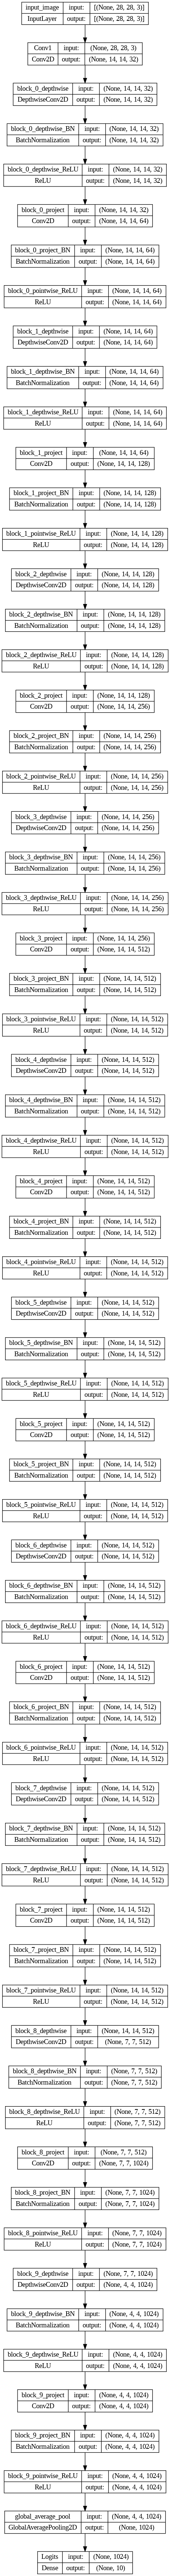

In [13]:
# build model
# create and compile model
model = create_model(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS, TRAINING_LR_MAX)
model.summary()
keras.utils.plot_model(model, 'cifar_model.png', show_shapes=True)

In [14]:
def lr_schedule(epoch):
    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))
    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)
        #max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))(math.pi/2.0))) + TRAINING_LR_FINAL
    # debug - learning rate display
    # print(epoch)
    # print(lr)
    return lr

In [15]:
# plot training accuracy and loss curves
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [16]:
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', save_best_only=True, monitor='val_loss', verbose=1)]
#compile & learning model

In [ ]:
initial_epoch_num = 0
history = model.fit(x=dataset_train,
                epochs=60,
                verbose=1, 
                callbacks=callbacks, 
                validation_data=dataset_test,
                initial_epoch=initial_epoch_num)


Epoch 1/60
1561/1563 [============================>.] - ETA: 0s - loss: 2.5775 - accuracy: 0.1950
Epoch 00001: val_loss did not improve from 1.52631
1563/1563 [==============================] - 49s 31ms/step - loss: 2.5772 - accuracy: 0.1951 - val_loss: 2.8406 - val_accuracy: 0.1000 - lr: 1.0000e-05
Epoch 2/60
1562/1563 [============================>.] - ETA: 0s - loss: 1.9763 - accuracy: 0.4201
Epoch 00002: val_loss did not improve from 1.52631
1563/1563 [==============================] - 48s 31ms/step - loss: 1.9763 - accuracy: 0.4200 - val_loss: 3.5141 - val_accuracy: 0.1000 - lr: 2.0800e-04
Epoch 3/60
1561/1563 [============================>.] - ETA: 0s - loss: 1.7389 - accuracy: 0.5168
Epoch 00003: val_loss did not improve from 1.52631
1563/1563 [==============================] - 48s 30ms/step - loss: 1.7387 - accuracy: 0.5168 - val_loss: 4.4029 - val_accuracy: 0.1000 - lr: 4.0600e-04
Epoch 4/60
1562/1563 [============================>.] - ETA: 0s - loss: 1.5213 - accuracy: 0.5944

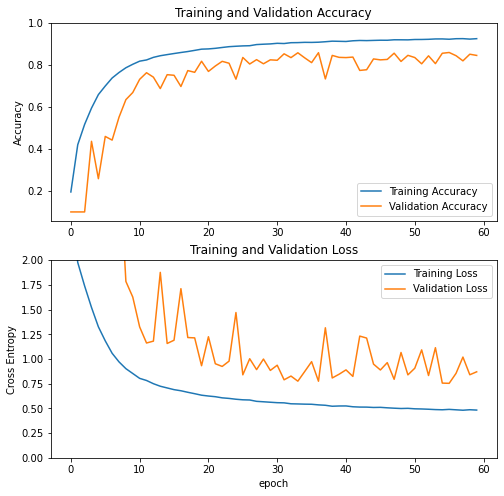

In [ ]:
plot_training_curves(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(x=dataset_test)
print('Test loss:     ', test_loss)
print('Test accuracy: ', test_accuracy)

313/313 [==============================] - 4s 12ms/step - loss: 0.8701 - accuracy: 0.8452
Test loss:      0.8700960278511047
Test accuracy:  0.8452000021934509
